# Using Pysersic for simple fits at maximum speed 

The main strength of `pysersic` is its ability to provide performant estimates (or direct samples) of the posterior on the parameters which define a parametric profile of choice vis a vis a galaxy image. 

That said, the techinques we have employed under the hood to make rendering model images as speedy as possible means that `pysersic` can technically also be used to simply minimize a chosen loss function to return a "best fit". 

To this end, we have recently added in the ability to use `pysersic` in this way, which in most cases should be relatively straightforward. 

In this walk through, we'll cover how to simply load up and fit an image as quickly as possible. As usual, we'll start by loading up our example galaxy:


In [1]:
import numpy as np


def load_data(n):
    im = np.load(f"examp_gals/gal{n}_im.npy")
    mask = np.load(f"examp_gals/gal{n}_mask.npy")
    sig = np.load(f"examp_gals/gal{n}_sig.npy")
    psf = np.load(f"examp_gals/gal{n}_psf.npy")
    return im, mask, sig, psf


im, mask, sig, psf = load_data(2)

The only new piece we need is the `FitSingleLoss` class from the `pysersic.minimize` module, along with our standard renderers. There is also an in-development `FastRenderer` where we sacrifice some accuracty for even more speed gains. 


In [2]:
from pysersic.minimize import FitSingleLoss, FastRenderer
from pysersic.rendering import FourierRenderer, HybridRenderer, PixelRenderer

We can then initialize our `FitSingleLoss` object with the data and a chosen renderer.

In [14]:
fitter = FitSingleLoss(
    data=im, sig=sig, psf=psf, mask=mask, renderer=FastRenderer, loss_func=None
)

In the above, we have not specified a loss function, which will tell the fitter to default to a builtin `chi2` loss. You can provide your own loss function if you wish, so long as it follows this convention: 

In [ ]:
def my_loss(data:jnp.array, model:jnp.array, sig:jnp.array, mask:jnp.array)-->float:
    return computed_loss 

Where the mask in this case is the one used internally by `pysersic`, computed as `jnp.logical_not(jnp.array(mask).astype(jnp.bool_))`. Thus, in your loss function, assume that True/1 corresponds to an *unmasked* pixel. For example, this is the built-in `chi2`: 

In [15]:
def chi2(self, data, model, sig, mask) -> float:
    # Apply the mask to both the data and model
    masked_residuals = ((data - model) * mask) / sig
    chi2_val = jnp.sum(masked_residuals**2)
    return chi2_val


As we can see, we multiply the residual by the mask (thus, values of 1 retain computed residuals while 0s serve to mask bad values). Be sure to use `jnp` (jax) when doing internal computations. We may make the set of loss functions available now for sampling automatically available in the future. 


To fit, we simply call the `.minimize_loss()` method. It uses the `SourceProperties` object, much like our `autoprior`, to determine a reasonable starting point and bounds for the minimization. We plan to allow you to pass initial params and bounds manually if you wish in the near future.

In [15]:
best_params, res = fitter.minimize_loss()

In [5]:
%%timeit 
best_params = fitter.minimize_loss()

361 ms ± 31.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Notice that for this example (cutout of ~100x100 pixels), the entire fit took  less than half a second.

Here, we dispense with fancy results objects and simply return an array of best-fit parameters, which is a simple dictionary containing: 

In [6]:
best_params

{'xc': Array(60.453598, dtype=float32),
 'yc': Array(59.262703, dtype=float32),
 'flux': Array(3712.6963, dtype=float32),
 'r_eff': Array(1.7432513, dtype=float32),
 'e1': Array(-0.04274858, dtype=float32),
 'e2': Array(0.00722308, dtype=float32),
 'n': Array(3.551771, dtype=float32)}

where `e1` and `e2` are a parameterization of the ellipticity and position angle. These can be converted to the more standard ellipticity and theta via a static method of the `FitSingleLoss`, passing an `r_eff`, and the `e1` and `e2`. The `r_eff` output is the same as the input, but is needed to perform the conversion.

In [7]:
FitSingleLoss.convert_params(best_params["r_eff"], best_params["e1"], best_params["e2"])

(Array(5.7158976, dtype=float32),
 Array(0.323247, dtype=float32),
 Array(-0.7017054, dtype=float32))

Which correspond to `r_eff`, `ellip`, and `theta` (in radians), respectively. 

We can use the fitter to create a model from our best-fitting parameters and compare to the data: 

In [16]:
model_image = fitter.create_model(best_params)

In [19]:
# define some plotting tools

import matplotlib.pyplot as plt


def plot_mod_data(im, model, mask=None, resid_range=1):
    # plot the observed data, the model, and the residuals
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    # Observed data
    vmin, vmax = np.percentile(im, [1, 99])
    if mask is not None:
        axs[0].imshow(
            np.ma.masked_array(im, mask=mask),
            origin="lower",
            cmap="gray_r",
            vmin=vmin,
            vmax=vmax,
        )
    else:
        axs[0].imshow(im, origin="lower", cmap="gray_r", vmin=vmin, vmax=vmax)
    axs[0].set_title("Observed Data")

    # Model
    if mask is not None:
        axs[1].imshow(
            np.ma.masked_array(model, mask=mask),
            origin="lower",
            cmap="gray_r",
            vmin=vmin,
            vmax=vmax,
        )
    else:
        axs[1].imshow(model, origin="lower", cmap="gray_r", vmin=vmin, vmax=vmax)
    axs[1].set_title("Fitted Model")

    # Residuals
    residuals = im - model
    if mask is not None:
        axs[2].imshow(
            np.ma.masked_array(residuals, mask=mask),
            origin="lower",
            cmap="RdBu",
            vmin=-resid_range,
            vmax=resid_range,
        )
    else:
        axs[2].imshow(
            residuals, origin="lower", cmap="RdBu", vmin=-resid_range, vmax=resid_range
        )
    axs[2].set_title("Residuals")

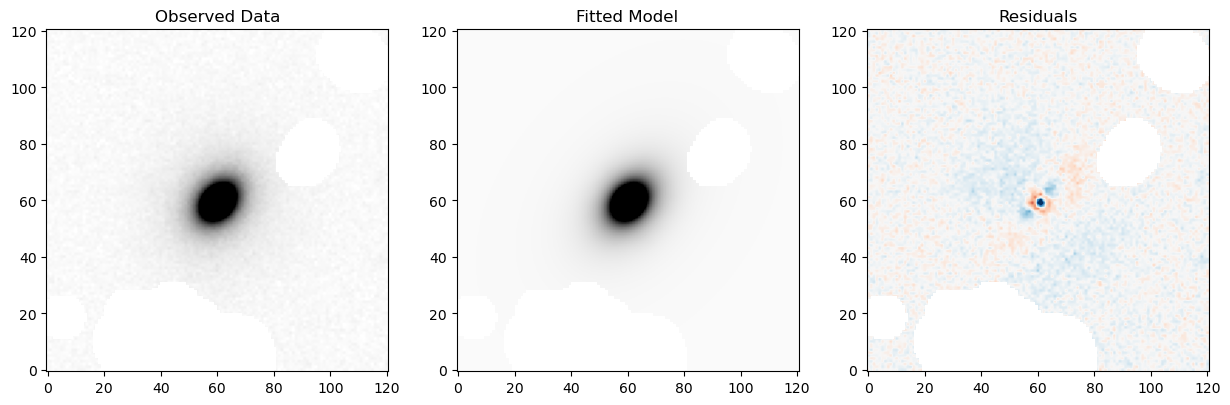

In [17]:
plot_mod_data(im, model_image, mask, resid_range=0.9)

We Also retrieved the result object from the minimization, from which we can obtain the minimized value of our loss function:

In [18]:
res.state.fun_val

Array(16521.896, dtype=float32, weak_type=True)

## Renderer Comparisons 

The `FastRenderer` is a few hundred miliseconds faster than the other renderers, clocking in at around ~350 ms. But is it also less accurate, due to its simplistic rendering procedure. 

Our three standard renderers are all more accurate, and still run in under 1 second for this test galaxy.

In [3]:
fitter = FitSingleLoss(
    data=im, sig=sig, psf=psf, mask=mask, renderer=FourierRenderer, loss_func=None
)

In [4]:
%%timeit 
best_params = fitter.minimize_loss()

520 ms ± 6.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [5]:
fitter = FitSingleLoss(
    data=im, sig=sig, psf=psf, mask=mask, renderer=HybridRenderer, loss_func=None
)

In [6]:
%%timeit 
best_params = fitter.minimize_loss()

801 ms ± 25.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [7]:
fitter = FitSingleLoss(
    data=im, sig=sig, psf=psf, mask=mask, renderer=PixelRenderer, loss_func=None
)

In [8]:
%%timeit 
best_params = fitter.minimize_loss()

637 ms ± 18.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Let's look at the magnitude of the residuals when using the `FourierRenderer`, the fastest of the three standard rendererers:

15728.721


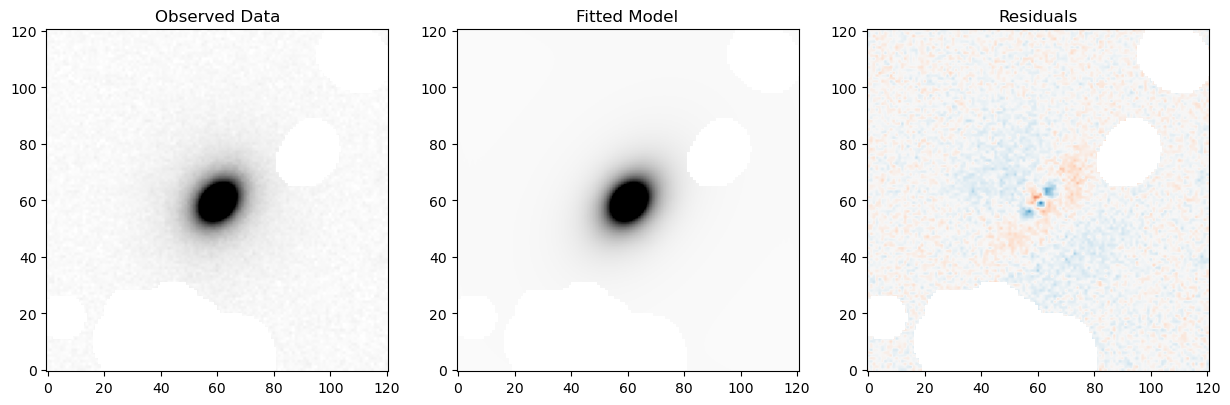

In [13]:
fitter = FitSingleLoss(
    data=im, sig=sig, psf=psf, mask=mask, renderer=FourierRenderer, loss_func=None
)
best_params, res = fitter.minimize_loss()
model_image = fitter.create_model(best_params)
plot_mod_data(im, model_image, mask, resid_range=0.9)
print(res.state.fun_val)

Our ploting code has the same limits imposed in the residual plot, so we can see how the fourier renderer has some additional flexibility in fitting the image that the `FastRenderer` doesn't, particularly in the center. 

This is reflected in our minimized `chi2`, which is 15728.721 in this Fourier run, compared to 16521.896 in the Fast run. 

In general, we thus recommend if you are using the minimization routines to quickly fit (or test) some galaxies, if the difference in a few hundred miliseconds is not a major bottleneck, then using one of the standard renderers is preferred. If you do use the `FastRenderer`, we recommend benchmarking against the others and ultimately using caution with the results.